In [1]:
#Importing neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Reading data
data=pd.read_csv('nyc_taxi_trip_duration.csv')

In [3]:
#Checking for null values

data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [4]:
#Checking for data type consistency

data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [5]:
# converting strings to datetime features
data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)
data['dropoff_datetime'] = pd.to_datetime(data.dropoff_datetime)

# Converting yes/no flag to 1 and 0
data['store_and_fwd_flag'] = 1 * (data.store_and_fwd_flag.values == 'Y')

In [6]:
#Feature engineering on datetime values

data['pickup_dayofweek'] = data['pickup_datetime'].dt.dayofweek
#data['dropoff_dayofweek'] = data['dropoff_datetime'].dt.dayofweek


data['pickup_month'] = data['pickup_datetime'].dt.month
#data['dropoff_month'] = data['dropoff_datetime'].dt.month

data['pickup_week'] = data['pickup_datetime'].dt.week
#data['dropoff_week'] = data['dropoff_datetime'].dt.week

data['pickup_day'] = data['pickup_datetime'].dt.day
#data['dropoff_day'] = data['dropoff_datetime'].dt.day


data['pickup_hour'] = data['pickup_datetime'].dt.hour
#data['dropoff_hour'] = data['dropoff_datetime'].dt.hour




In [7]:
#Calculating trip distance from longitude and Latitude values

from math import sin, cos, sqrt, atan2, radians

def Distance(row):
    R = 6373.0  # approximate radius of earth in km
    x = radians(row['pickup_latitude'])
    y = radians(row['pickup_longitude'])
    x1 = radians(row['dropoff_latitude'])
    y1 = radians(row['dropoff_longitude'])
    
    d1 = y1 - y
    d2 = x1 - x
    
    x3 = sin(d2 / 2)**2 + cos(x) * cos(x1) * sin(d1 / 2)**2
    y3 = 2 * atan2(sqrt(x3), sqrt(1 - x3))
    result = R * y3
    
    return result

In [8]:
data['trip_distance'] = data.apply(lambda row: Distance(row), axis= 1)
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_dayofweek,pickup_month,pickup_week,pickup_day,pickup_hour,trip_distance
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,400,0,2,9,29,16,1.199449
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,1100,4,3,10,11,23,4.130407
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,6,2,7,21,17,7.253029
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,1141,1,1,1,5,9,2.361839
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,848,2,2,7,17,6,4.329893


In [9]:
#Checking for outliers

data['trip_duration'].describe()/3600


count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

In [10]:
#removing outliers

Q1 = data['trip_duration'].quantile(0.25)
Q3 = data['trip_duration'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (data['trip_duration'] >= Q1 - 1.5 * IQR) & (data['trip_duration'] <= Q3 + 1.5 *IQR)
data_cleaned= data.loc[filter]  

In [11]:
data_cleaned['trip_duration'].describe()/3600

count    192.321944
mean       0.203375
std        0.124510
min        0.000278
25%        0.106667
50%        0.175556
75%        0.275556
max        0.581111
Name: trip_duration, dtype: float64

In [12]:
data_predict=data_cleaned

In [13]:
#seperating independent and dependent variables
x = data_predict.drop(['id','dropoff_datetime','pickup_datetime','dropoff_longitude','pickup_longitude','dropoff_latitude','pickup_latitude','trip_duration'],axis=1)
y =data_predict['trip_duration']
x.shape, y.shape

((692359, 9), (692359,))

In [14]:
# Importing the train test split function
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x , y, random_state=56)

In [15]:
#Importing the required libraries

from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [16]:
# Creating instance of Linear Regresssion
lr = LR()

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression()

In [17]:
#Predicting over train set

train_predict = lr.predict(train_x)
k = mae(train_predict, train_y)
print('Training Mean Absolute Error', k )


Training Mean Absolute Error 264.7329950968183


In [18]:
#Predicting over test set

test_predict = lr.predict(test_x)
k = mae(test_predict, test_y)
print('Test Mean Absolute Error    ', k )

Test Mean Absolute Error     264.7719696262622


In [19]:
#Checking for assumptions of Linear Regression

In [20]:
# Arranging and calculating the Residuals
residuals = pd.DataFrame({
    'fitted values' : test_y,
    'predicted values' : test_predict,
})

residuals['residuals'] = residuals['fitted values'] - residuals['predicted values']
residuals.head()


,fitted values,predicted values,residuals
534310,145,591.605470,-446.605470
464241,708,840.857901,-132.857901
357966,1075,745.754859,329.245141
260631,91,510.685773,-419.685773
389941,592,634.017476,-42.017476


In [21]:
residuals.residuals[:]

534310   -446.605470
464241   -132.857901
357966    329.245141
260631   -419.685773
389941    -42.017476
             ...    
520063   -418.913960
279803    527.559747
118722    471.836969
561207    -88.772592
323847   -352.693497
Name: residuals, Length: 173090, dtype: float64

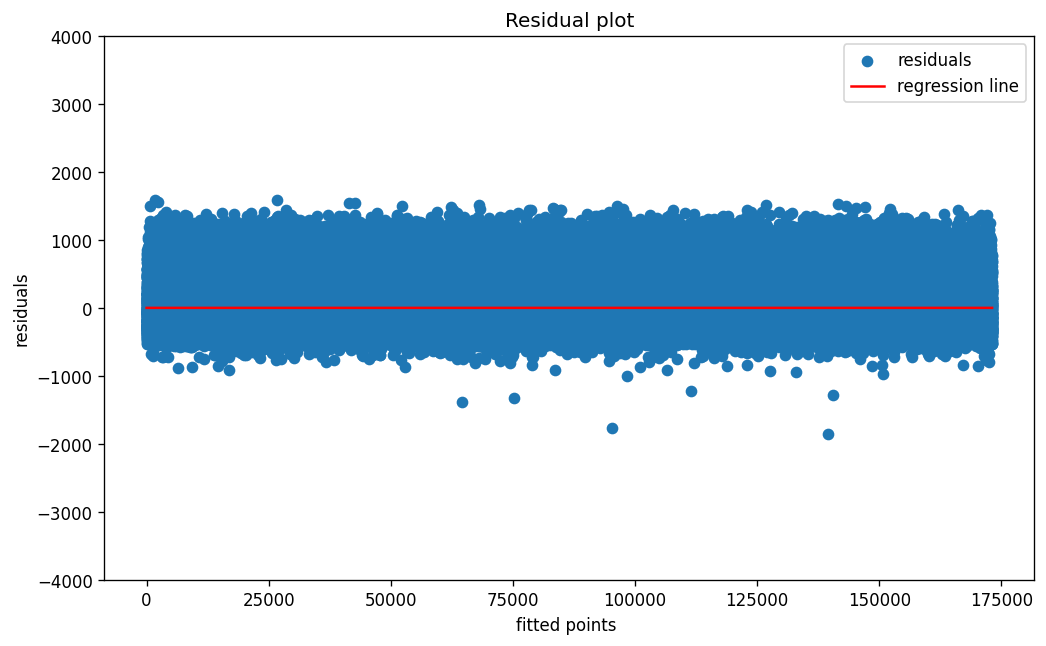

In [22]:
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,173090)
k = [0 for i in range(0,173090)]
plt.scatter( f, residuals.residuals[:], label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.ylim(-4000, 4000)
plt.legend()

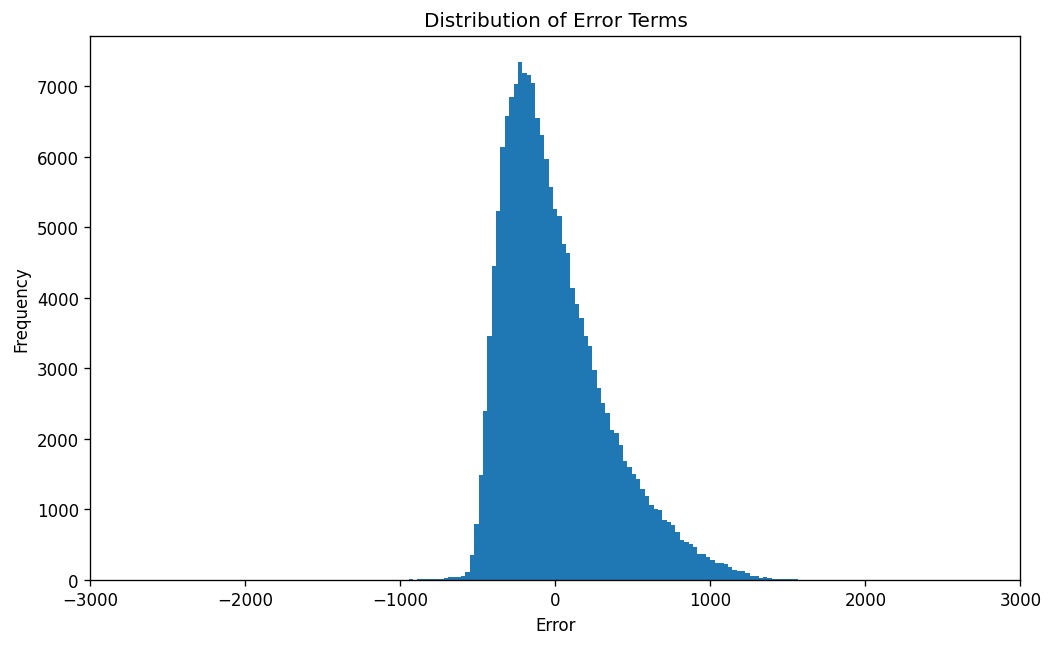

In [23]:
# Histogram for distribution
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
plt.hist(residuals.residuals, bins = 900)
plt.xlim(-3000,3000)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Error Terms')
plt.show()

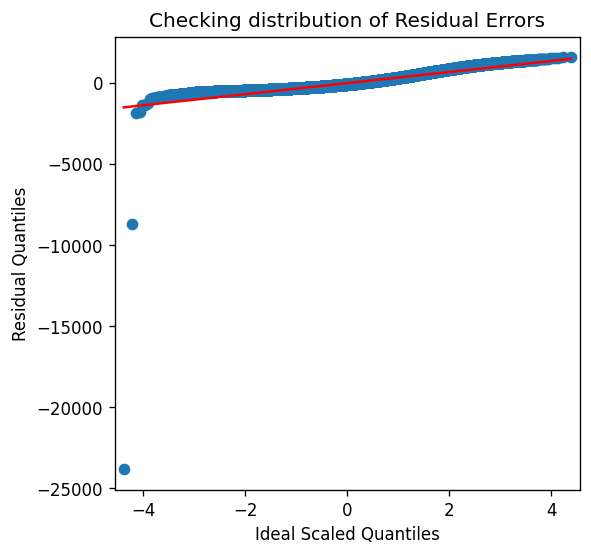

In [24]:
# importing the QQ-plot from the from the statsmodels
from statsmodels.graphics.gofplots import qqplot


## Plotting the QQ plot
fig, ax = plt.subplots(figsize=(5,5) , dpi = 120)
qqplot(residuals.residuals, line = 's' , ax = ax)
plt.ylabel('Residual Quantiles')
plt.xlabel('Ideal Scaled Quantiles')
plt.title('Checking distribution of Residual Errors')
plt.show()

<h2> Normalized Linear Regression <h2>

In [25]:
# Creating instance of Linear Regresssion
lr = LR (normalize = True)

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(normalize=True)

In [26]:
train_predict = lr.predict(train_x)
k = mae(train_predict, train_y)
print('Training Mean Absolute Error', k )

Training Mean Absolute Error 264.7329950968183


In [27]:
test_predict = lr.predict(test_x)
k = mae(test_predict, test_y)
print('Test Mean Absolute Error    ', k )


Test Mean Absolute Error     264.77196962626215


In [28]:

lr.coef_

array([ 1.14116649,  3.40151882, 31.71710135, -7.29893755, 14.99579747,
       -1.14886777,  0.47834498,  3.28054102, 76.7478524 ])

Text(0.5, 1.0, 'Normalized Coefficient plot')

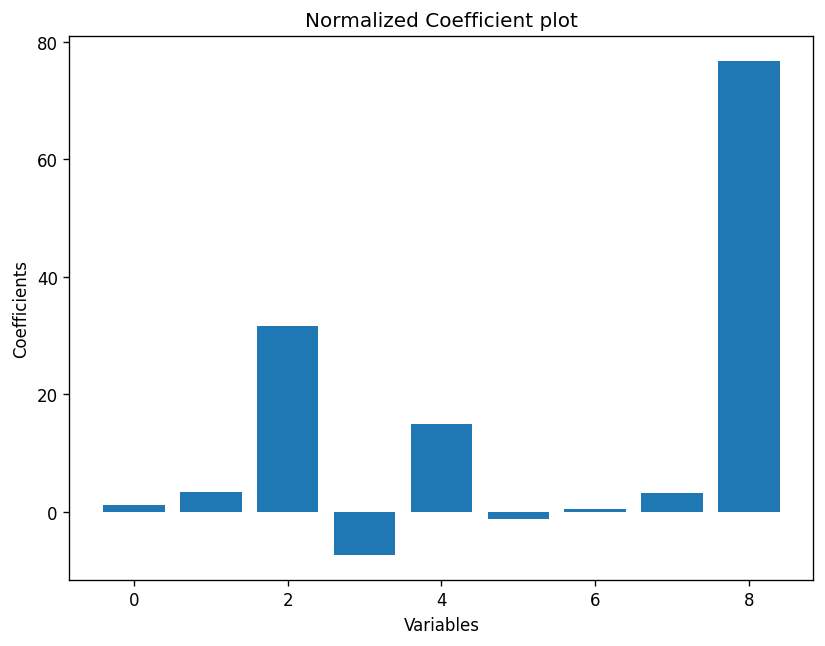

In [29]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
y = lr.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Normalized Coefficient plot')

In [30]:
x = data_predict.drop(['id','dropoff_datetime','pickup_datetime','dropoff_longitude','pickup_longitude','dropoff_latitude','pickup_latitude','trip_duration'],axis=1)
y =data_predict['trip_duration']
x.shape, y.shape

((692359, 9), (692359,))

In [31]:
Coefficients = pd.DataFrame({
    'Variable'    : x.columns,
    'coefficient' : lr.coef_
})
Coefficients

,Variable,coefficient
0,vendor_id,1.141166
1,passenger_count,3.401519
2,store_and_fwd_flag,31.717101
3,pickup_dayofweek,-7.298938
4,pickup_month,14.995797
5,pickup_week,-1.148868
6,pickup_day,0.478345
7,pickup_hour,3.280541
8,trip_distance,76.747852


In [32]:
#taking the variables who's coefficient is greater than 0.5
sig_var = Coefficients[Coefficients.coefficient > 0.5]

In [33]:
subset = data_predict[sig_var['Variable'].values]
subset.head()

,vendor_id,passenger_count,store_and_fwd_flag,pickup_month,pickup_hour,trip_distance
0,2,1,0,2,16,1.199449
1,1,2,0,3,23,4.130407
2,2,2,0,2,17,7.253029
3,2,6,0,1,9,2.361839
4,1,1,0,2,6,4.329893


In [34]:
# Importing the train test split function
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(subset, y , random_state = 56)

In [35]:
# Creating instance of Linear Regresssion with Normalised Data
lr = LR(normalize = True)

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(normalize=True)

In [36]:
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
k = mae(train_predict, train_y)
print('Training Mean Absolute Error', k )

Training Mean Absolute Error 265.10323378622167


In [37]:
# Predicting over the Test Set and calculating error
test_predict = lr.predict(test_x)
k = mae(test_predict, test_y)
print('Test Mean Absolute Error    ', k )

Test Mean Absolute Error     265.1485470433406


Text(0.5, 1.0, 'Normalized Coefficient plot')

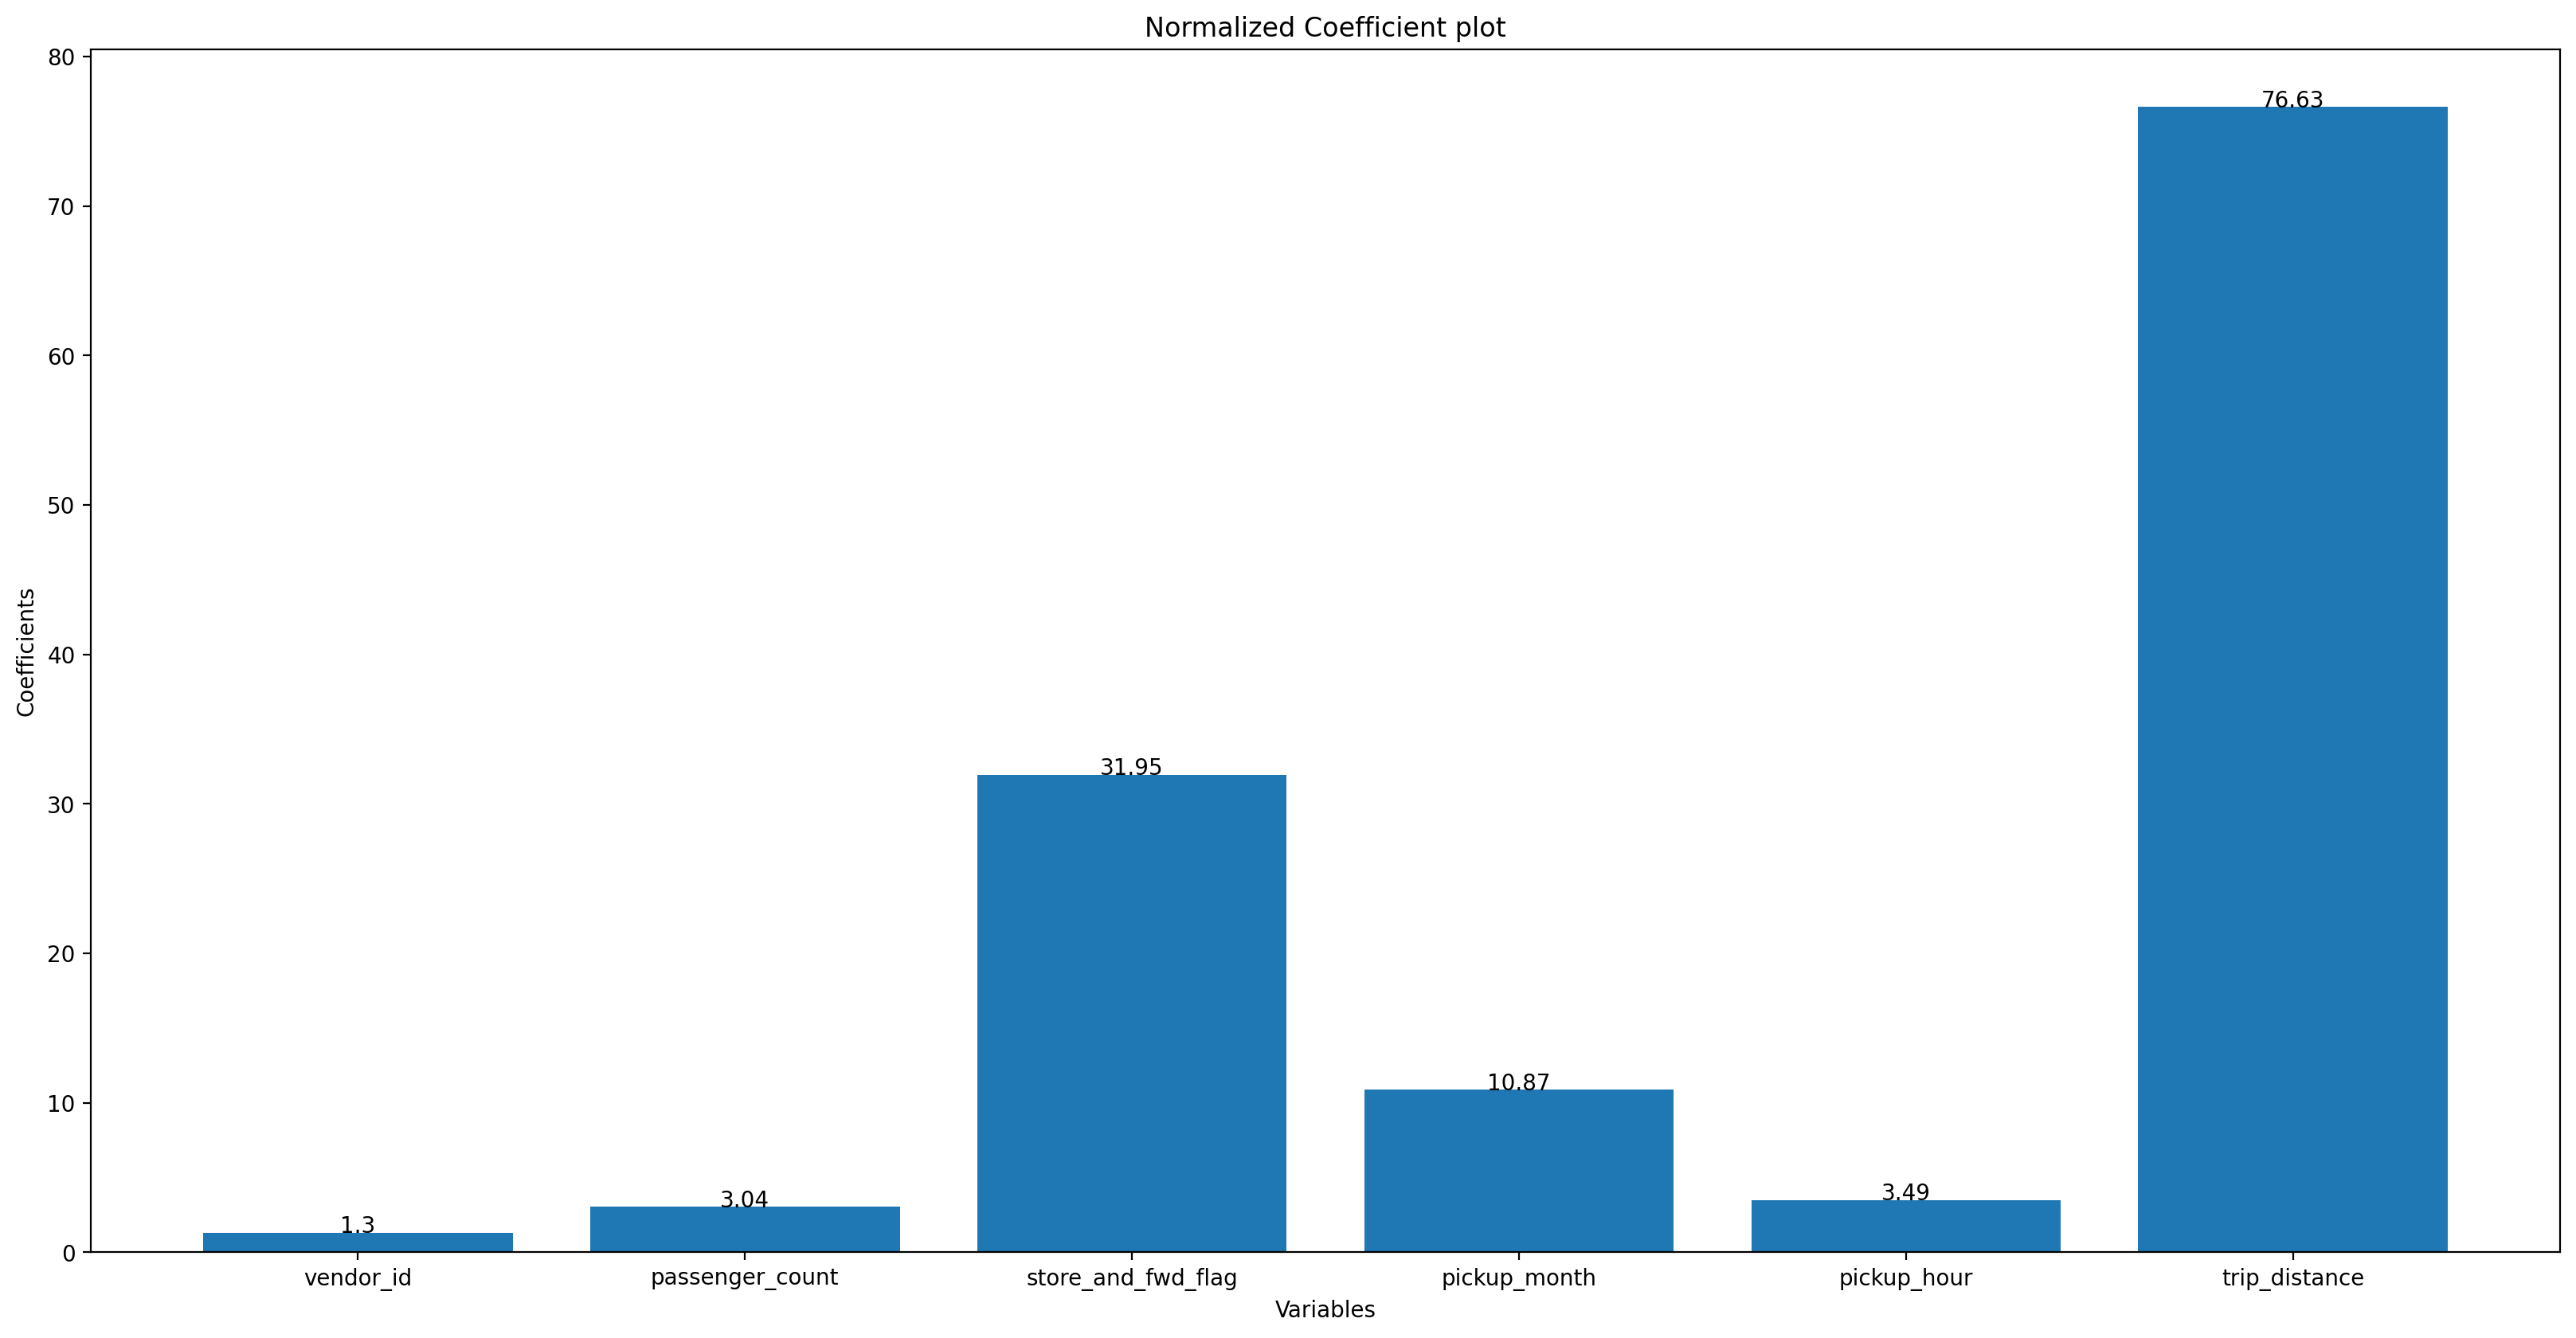

In [38]:
#Plotting Normalized Coefficients


x_axis=Coefficients[Coefficients['coefficient']>0.5]

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha = 'center')

plt.figure(figsize=(20, 10), dpi=200, facecolor='w', edgecolor='b')
y = np.round(lr.coef_,2)
addlabels(x_axis['Variable'],y)
plt.bar( x_axis['Variable'] , y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Normalized Coefficient plot')

In [39]:
#Evaluation
trs=lr.score(train_x,train_y)
tss=lr.score(test_x,test_y)

print("Train Score:", trs)
print("Test Score:", tss)

k = mse(train_predict, train_y)
print('Train MSE    ', k )
m = mse(test_predict, test_y)
print('Test MSE    ', m )


j=mse(train_predict,train_y,squared=False)
print('Train RMSE   ',j)
n=mse(test_predict,test_y,squared=False)
print('Test RMSE   ',n)

l=mae(train_predict, train_y)
print('Train MAE    ',l)
o=mae(test_predict, test_y)
print('Test MAE    ',o)




Train Score: 0.3419285967082809
Test Score: 0.42137092473807924
Train MSE     132002.13560725737
Test MSE     116822.03626169983
Train RMSE    363.3209815125702
Test RMSE    341.79238765908735
Train MAE     265.10323378622167
Test MAE     265.1485470433406


In [40]:
name1=['Train Score','Test Score']
values1=[trs,tss]
name2=['Train MSE','Test MSE']
values2=[k,m]
name3=['Train RMSE','Test RMSE']
values3=[j,n]
name4=['Train MAE','Test MAE']
values4=[l,o]


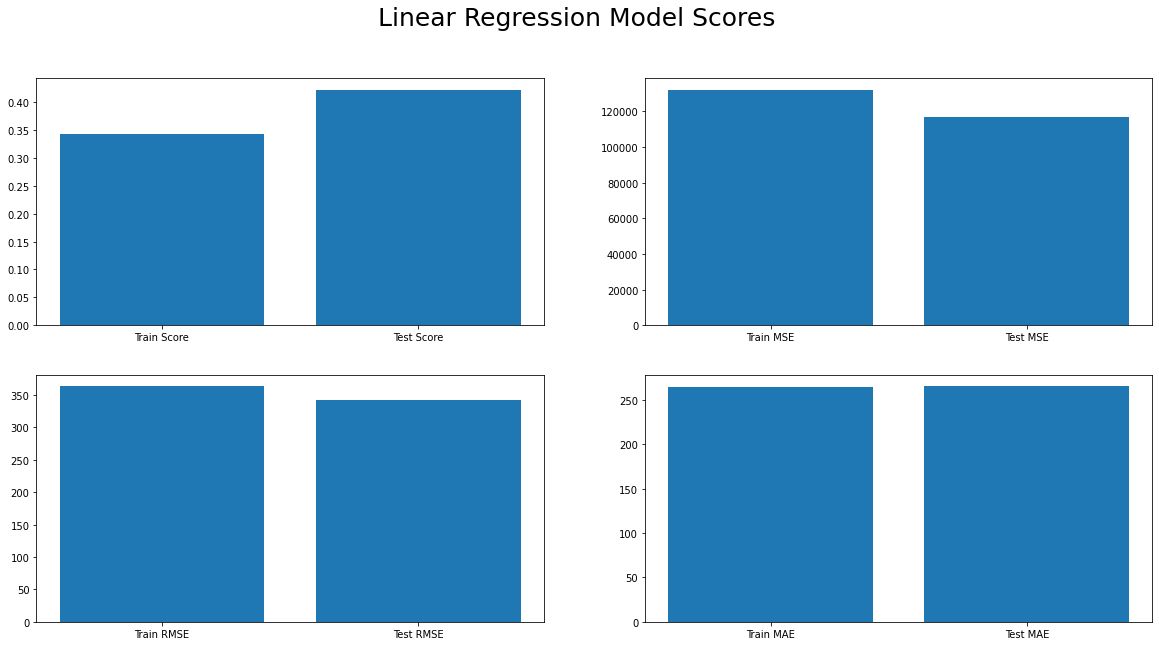

In [41]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
fig.suptitle("Linear Regression Model Scores",fontsize=25)
ax[0, 0].bar(name1, values1)
ax[0, 1].bar(name2, values2)
ax[1, 0].bar(name3, values3)
ax[1, 1].bar(name4, values4)
plt.show()

In [42]:
#Implementing Ridge Regularization

#Importing required libraries

from sklearn.linear_model import LinearRegression, Ridge, Lasso


In [43]:
#Assigning different values of alpha

alpha_ridge = [0, 1e-8, 1e-4, 1e-2 , 1 , 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 10, 20]

In [44]:
# defining a function which will fit ridge regression model and return the coefficients
def ridge_regression(train_x, train_y, test_x, test_y, alpha):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(train_x,train_y)
    train_y_pred = ridgereg.predict(train_x)
    test_y_pred = ridgereg.predict(test_x)
    
    #Return the result in pre-defined format
    mrss_train = sum((train_y_pred-train_y)**2)/train_x.shape[0]
    ret = [mrss_train]
    
    mrss_test = sum((test_y_pred-test_y)**2)/test_x.shape[0]
    ret.extend([mrss_test])
    
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    
    return ret

In [45]:
#Initialize the dataframe for storing coefficients.
col = ['mrss_train','mrss_test','intercept'] + ['coef_Var_%d'%i for i in range(1,7)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,15)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

In [46]:
for i in range(15):
    coef_matrix_ridge.iloc[i,] = ridge_regression(train_x, train_y, test_x, test_y, alpha_ridge[i])

In [47]:
coef_matrix_ridge['mrss_train']

alpha_0         132002.135607
alpha_1e-08     132002.135607
alpha_0.0001    132002.136303
alpha_0.01      132008.955794
alpha_1         149251.369802
alpha_1.5       156806.421952
alpha_2         162597.987161
alpha_2.5       167103.998645
alpha_3         170685.230575
alpha_3.5       173590.109773
alpha_4         175989.257108
alpha_4.5       178001.931913
alpha_5         179713.348558
alpha_10        188736.502864
alpha_20        194241.274194
Name: mrss_train, dtype: object

In [48]:
coef_matrix_ridge['mrss_test']

alpha_0         116822.036262
alpha_1e-08      116822.03658
alpha_0.0001    116825.222799
alpha_0.01      117142.805076
alpha_1         146135.077225
alpha_1.5       155182.187895
alpha_2         161799.251047
alpha_2.5       166812.186373
alpha_3         170728.430374
alpha_3.5       173867.123195
alpha_4         176436.478374
alpha_4.5       178577.283375
alpha_5         180387.825539
alpha_10        189802.362884
alpha_20        195452.833457
Name: mrss_test, dtype: object

In [49]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,mrss_train,mrss_test,intercept,coef_Var_1,coef_Var_2,coef_Var_3,coef_Var_4,coef_Var_5,coef_Var_6
alpha_0,1.3e+05,1.2e+05,4.2e+02,1.3,3,32,11,3.5,77
alpha_1e-08,1.3e+05,1.2e+05,4.2e+02,1.3,3,32,11,3.5,77
alpha_0.0001,1.3e+05,1.2e+05,4.2e+02,1.3,3,32,11,3.5,77
alpha_0.01,1.3e+05,1.2e+05,4.2e+02,1.3,3,32,11,3.4,76
alpha_1,1.5e+05,1.5e+05,5.8e+02,1.7,1.8,28,5.4,1.4,38
alpha_1.5,1.6e+05,1.6e+05,6.1e+02,1.5,1.5,24,4.3,1,31
alpha_2,1.6e+05,1.6e+05,6.3e+02,1.3,1.3,21,3.6,0.82,25
alpha_2.5,1.7e+05,1.7e+05,6.4e+02,1.2,1.1,19,3,0.68,22
alpha_3,1.7e+05,1.7e+05,6.6e+02,1.1,0.97,17,2.7,0.58,19
alpha_3.5,1.7e+05,1.7e+05,6.6e+02,0.98,0.87,15,2.4,0.51,17


<Figure size 2160x720 with 0 Axes>

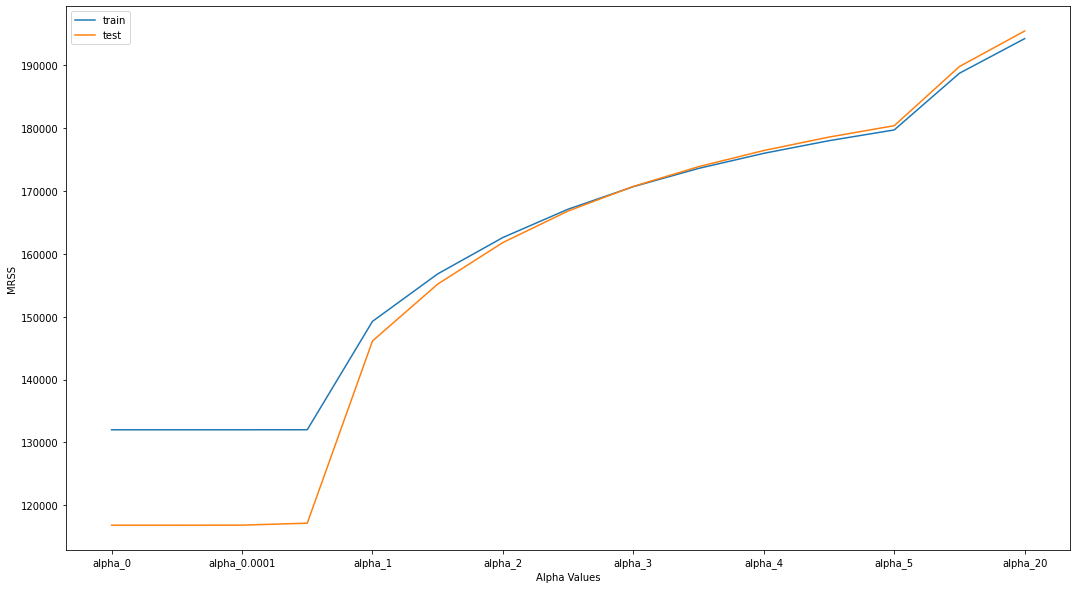

In [50]:
plt.figure(figsize =(30,10))
coef_matrix_ridge[['mrss_train','mrss_test']].plot(figsize =(18,10))
plt.xlabel('Alpha Values')
plt.ylabel('MRSS')
plt.legend(['train', 'test'])
plt.show()

In [51]:
#From the above graph we can see that that the apha value 1.5 or 2 is the best for the model
# Building and fitting the Ridge Regression model
ridgeModelChosen = Ridge(alpha = 1.5)
ridgeModelChosen.fit(train_x,train_y)
 
# Evaluating the Ridge Regression model
print(ridgeModelChosen.score(train_x,train_y))
print(ridgeModelChosen.score(test_x,test_y))

0.34192859669990483
0.4213708915445371
